In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from segmenter import SamAutomaticMaskGenerator, build_sam,sam_checkpoint, Voxelize, VOXEL_SIZE


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:

mask_generator = SamAutomaticMaskGenerator( build_sam(checkpoint=sam_checkpoint).to(device="cuda"),
  points_per_side=64,
            pred_iou_thresh=0.7,
            crop_n_layers=0)



In [4]:
voxelize = Voxelize(voxel_size=VOXEL_SIZE, mode="train", keys=("coord", "color", "group", "normals"))

In [11]:
from psdstaticdataset import StaticDataset
from pathlib import Path
from matplotlib import pyplot as plt
from segmenter import seg_pcd, get_workspace_voxels, get_pcd
import open3d as o3d

In [6]:
intermediate_outputs_path = Path("/home/david/projects/deg/dependencies/SegmentAnything3D/outputs/notebook")

In [8]:
scene_path = Path("/home/david/projects/deg/results/sam3d-mask-static/embodied_gaussians_real/single1_aruco/run_1/scene.pkl")
from segmenter import SceneSetup
import pickle
scene = pickle.load(open(scene_path, "rb"))
obs = pickle.load(open(scene_path.parent / "observations.pkl", "rb"))


In [13]:
workspace_voxels = get_workspace_voxels(scene)
o3d.visualization.draw_geometries([workspace_voxels])

In [76]:
seg_dict, instance_groups, group_mapping = seg_pcd(obs, mask_generator, voxelize, None, intermediate_outputs_path, workspace_voxels)


Round 1: merging 5 point clouds
group_0: ['back'] , group_1: ['side'] with offset 151
merging group 1 - 94 and group 0 - 150 due to high overap, overlap: 47706, total_count: 56556.0, group_1 - 94 count: 67708,  and group_0 - 150 count: 56556
not merging group 1 - 87 and group 0 - 150 due to low ratio 513 / 2060.0 = 0.24902912621359224 < 0.5
merging group 1 - 91 and group 0 - 136 due to high overap, overlap: 1270, total_count: 1526.0, group_1 - 91 count: 1860,  and group_0 - 136 count: 1526
merging group 1 - 20 and group 0 - 136 due to high overap, overlap: 50, total_count: 52.0, group_1 - 20 count: 52,  and group_0 - 136 count: 1526
not merging group 1 - 28 and group 0 - 150 due to low ratio 1 / 738.0 = 0.0013550135501355014 < 0.5
group_0: ['side'] , group_1: ['back'] with offset 240
merging group 1 - 150 and group 0 - 150 due to high overap, overlap: 47710, total_count: 56556.0, group_1 - 150 count: 56556,  and group_0 - 150 count: 67735
not merging group 1 - 146 and group 0 - 150 due

In [77]:
# investigate the grouping. 
# first question is why did tripod left and back not have their table instance merged as part of round 2.
import pickle
round1_group_2 = pickle.load(open(Path("outputs") / "notebook" / "round_1" / "group_2" / "group_instances.pkl", "rb"))
round1_group_1 = pickle.load(open(Path("outputs") / "notebook" / "round_1" / "group_1" / "group_instances.pkl", "rb"))

In [78]:
import numpy as np
back_ids, back_counts = np.unique(round1_group_1['back'], return_counts=True)
side_ids, side_counts = np.unique(round1_group_1['side'], return_counts=True)
back_ids, back_counts, side_ids, side_counts
# 2 is T. 3 is table.

(array([-1,  2,  3,  8,  9], dtype=int32),
 array([559261,   8385, 353285,    140,    529]),
 array([-1,  2,  3,  4,  5,  6,  7], dtype=int32),
 array([261316,  12518, 614565,   1217,     69,  27392,   4523]))

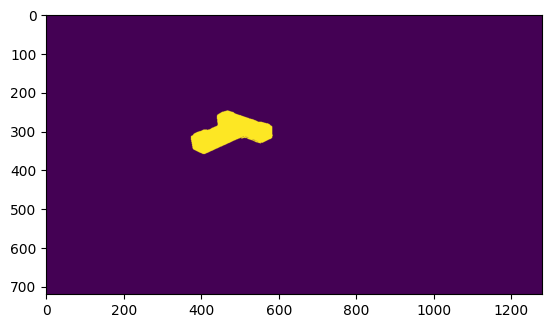

In [79]:
plt.imshow(round1_group_1['side'] == 2)
plt.show()





In [80]:
top_ids, top_counts = np.unique(round1_group_2['topleft'], return_counts=True)
tripod_ids, tripod_counts = np.unique(round1_group_2['tripodback'], return_counts=True)
top_ids, top_counts, tripod_ids, tripod_counts


(array([-1,  0,  1], dtype=int32),
 array([622049,   3949, 295602]),
 array([-1,  0,  1], dtype=int32),
 array([458968,   9640, 452992]))

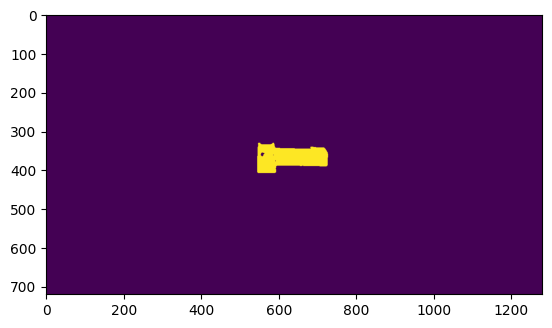

In [81]:
plt.imshow(round1_group_2['tripodback'] == 0)

In [82]:
# plot thickens, this group doesn't have the table at all!.
round0_group_4= pickle.load(open(Path("outputs") / "notebook" / "round_0" / "group_4" / "group_instances.pkl", "rb"))
round0_group_3= pickle.load(open(Path("outputs") / "notebook" / "round_0" / "group_3" / "group_instances.pkl", "rb"))

tripod_ids, tripod_counts = np.unique(round0_group_4['tripodback'], return_counts=True)
top_ids, top_counts = np.unique(round0_group_3['topleft'], return_counts=True)
tripod_ids, tripod_counts, top_ids, top_counts


(array([ -1,   7,  13,  30,  49,  71,  74,  89,  95, 104, 107, 114, 115,
        119, 122, 129, 133, 138, 141, 143, 145, 152, 158], dtype=int32),
 array([456200,     21,     52,    173,     81,  10258,   1306,     74,
           282,     61,     32,     25,   2564,     33,    419,   1587,
             7,      6,   1407,    291,   9221,    505, 436995]),
 array([ -1,  23,  88,  91, 104, 110], dtype=int32),
 array([622037,     73,     12,   3949,    401, 295128]))

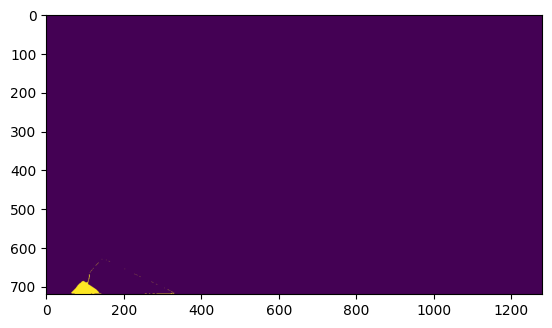

In [83]:
plt.imshow(round0_group_4['tripodback'] == 129)

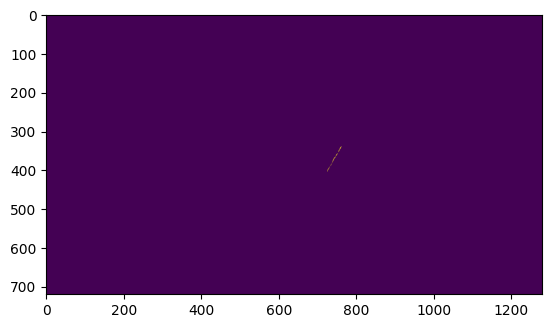

In [84]:
plt.imshow(round0_group_3['topleft'] == 23)
plt.show()
# topleft 110 is the table, 91 is the T

In [ ]:
# topleft 110 is the table, 91 is the T
# tripod back 158 is the table, 145 is the T


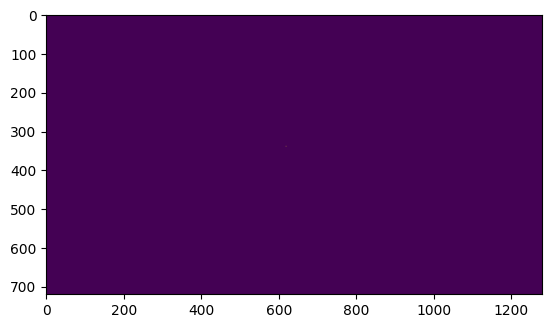

In [73]:
import sam3d
gt_group_ids = sam3d.get_sam(d.frames[0].color.cpu().numpy(), mask_generator)
plt.imshow(gt_group_ids==65)





In [76]:
from segmenter import get_dataset_frame_from_observation_frame, get_pcd
frame = d.frames[0]
#frame = get_dataset_frame_from_observation_frame(obs_frame)
pcd_dict, group_ids = get_pcd(frame, bbox=None, mask_generator=mask_generator, segment_cache_path=None, workspace_voxels=workspace_voxels)

removing color -1.0 because it has 3824 / 68478 points in the workspace
removing color 0.0 because it has 0 / 18 points in the workspace
removing color 1.0 because it has 0 / 317 points in the workspace
keeping color 3.0 because it has 36 / 93 points in the workspace
removing color 4.0 because it has 0 / 13720 points in the workspace
removing color 5.0 because it has 0 / 2522 points in the workspace
removing color 6.0 because it has 0 / 1501 points in the workspace
removing color 7.0 because it has 0 / 1004 points in the workspace
removing color 8.0 because it has 0 / 1122 points in the workspace
removing color 9.0 because it has 0 / 762 points in the workspace
removing color 11.0 because it has 0 / 568 points in the workspace
keeping color 12.0 because it has 11 / 23 points in the workspace
removing color 13.0 because it has 0 / 306 points in the workspace
removing color 15.0 because it has 22 / 2015 points in the workspace
removing color 17.0 because it has 0 / 5108 points in the wor

In [12]:
[f.name for f in obs.frames]

['front_right_camera',
 'top_left_camera',
 'top_right_camera',
 'front_left_camera',
 'rear_camera',
 'robot_camera']

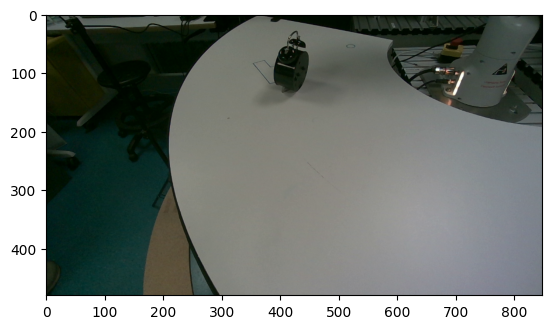

In [18]:
plt.imshow(obs.frames[0].color)

In [32]:
from segmenter import get_dataset_frame_from_observation_frame, get_pcd
obs_frame= obs.frames[0]
frame = get_dataset_frame_from_observation_frame(obs_frame)
pcd_dict, group_ids = get_pcd(frame, bbox=None, mask_generator=mask_generator, segment_cache_path=None, workspace_voxels=workspace_voxels)

removing color -1.0 because it has 2925 / 23653 points in the workspace
removing color 2.0 because it has 14 / 238 points in the workspace
removing color 3.0 because it has 0 / 17 points in the workspace
removing color 6.0 because it has 4 / 70 points in the workspace
removing color 7.0 because it has 0 / 58 points in the workspace
keeping color 8.0 because it has 3 / 3 points in the workspace
removing color 9.0 because it has 14 / 32 points in the workspace
removing color 14.0 because it has 0 / 435 points in the workspace
removing color 15.0 because it has 0 / 84 points in the workspace
removing color 17.0 because it has 1 / 23 points in the workspace
removing color 18.0 because it has 0 / 33 points in the workspace
removing color 19.0 because it has 0 / 10 points in the workspace
keeping color 20.0 because it has 34 / 34 points in the workspace
removing color 21.0 because it has 295 / 1047 points in the workspace
removing color 22.0 because it has 0 / 314 points in the workspace
rem

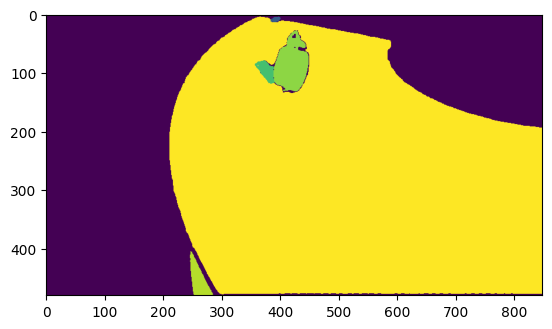

In [33]:
plt.imshow(group_ids)

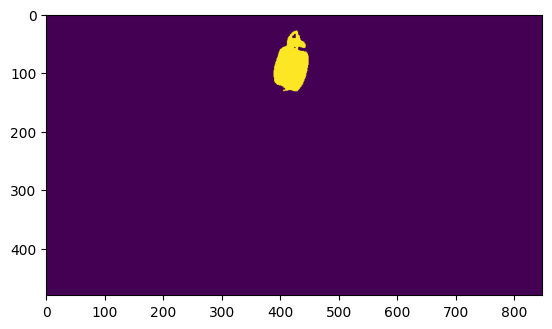

In [25]:
import sam3d
gt_group_ids = sam3d.get_sam(frame.color.cpu().numpy(), mask_generator)
plt.imshow(gt_group_ids==58)

In [29]:
frame.depth[gt_group_ids==58].shape

torch.Size([4199])

In [31]:
(frame.depth[gt_group_ids==58] > 0).sum()

tensor(3241, device='cuda:0')

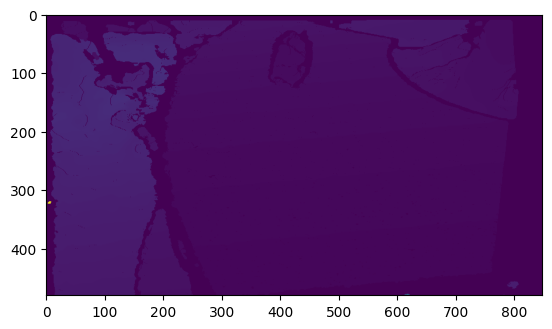

In [27]:
plt.imshow(frame.depth.cpu().numpy())

In [22]:
pcd_dict

{'coord': array([], shape=(0, 3), dtype=float64),
 'color': array([], shape=(0, 3), dtype=float64),
 'normals': array([], shape=(0, 3), dtype=float64),
 'group': array([], dtype=int16),
 'color_names': ['front_right_camera']}

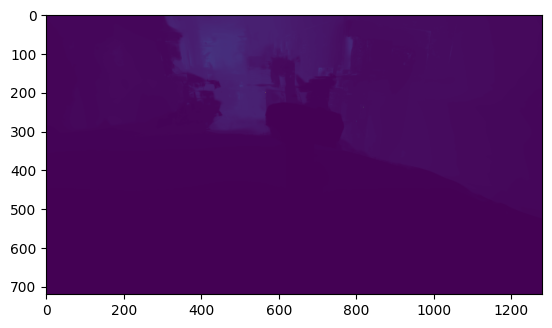

In [80]:
plt.imshow(frame.depth.cpu().numpy())

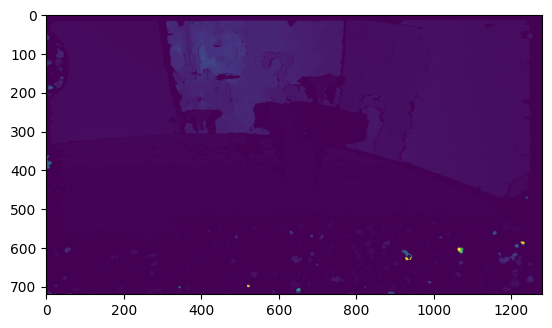

In [79]:
plt.imshow(d.frames[0].depth.cpu().numpy())

(720, 1280)

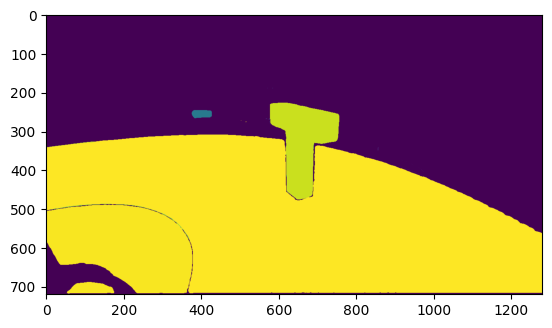

In [21]:
plt.imshow(group_ids)
group_ids.shape

In [32]:
ids, counts = np.unique(group_ids, return_counts=True)
counts_dict = {id: count for id, count in zip(ids, counts)}
counts_dict


{-1: 477842,
 3: 93,
 12: 23,
 34: 952,
 61: 22,
 65: 2,
 70: 465,
 76: 106,
 78: 24338,
 84: 66710,
 85: 351047}

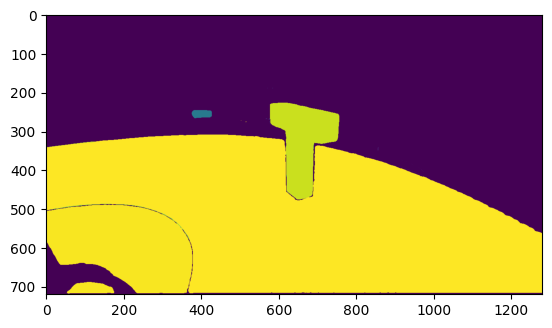

In [48]:
plt.imshow(group_ids)

In [13]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pcd_dict['coord'])
pcd.colors = o3d.utility.Vector3dVector(pcd_dict['color'])

pcd_dict['group']

o3d.visualization.draw_geometries([pcd])

In [14]:
import numpy as np
np.unique(pcd_dict['group'])

array([ 3, 12, 34, 61, 65, 70, 76, 78, 84, 85], dtype=int16)

In [15]:
dict = {v: i  for i, v in enumerate(np.unique(pcd_dict['group']))} 
seq_group = np.vectorize(dict.get)(pcd_dict['group'])
np.unique(seq_group)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [16]:
from matplotlib import colormaps

colors = list(colormaps['tab20'].colors)

seq_group_colors = np.array([colors[i % len(colors)] for i in seq_group])

seq_group.shape






(187117,)

In [18]:
seq_group_colors.shape

(187117, 3)

In [17]:
dict

{3: 0, 12: 1, 34: 2, 61: 3, 65: 4, 70: 5, 76: 6, 78: 7, 84: 8, 85: 9}

In [19]:
from matplotlib import colormaps
colors = list(colormaps['tab20'].colors)
dict = {v: i  for i, v in enumerate(np.unique(pcd_dict['group']))} 
seq_group = np.vectorize(dict.get)(pcd_dict['group'])
np.unique(seq_group)

seq_group_colors = np.array([colors[i % len(colors)] for i in seq_group])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pcd_dict['coord'])
pcd.colors = o3d.utility.Vector3dVector(seq_group_colors)

o3d.visualization.draw_geometries([pcd])

In [15]:
import numpy as np

In [52]:
pcd_dict, group_ids = get_pcd(frame, bbox=None, mask_generator=mask_generator, segment_cache_path=None, workspace_voxels=None)

pcd_groups = o3d.geometry.PointCloud()
pcd_groups.points = o3d.utility.Vector3dVector(pcd_dict['coord'])
pcd_groups.colors = o3d.utility.Vector3dVector(pcd_dict['group'].astype(np.float32).reshape(-1, 1).repeat(3, axis=1))


unique_group_ids, group_id_counts = np.unique(group_ids, return_counts=True)
count_dict = {g: c for g, c in zip(unique_group_ids, group_id_counts)}


indicies = np.arange(len(pcd_groups.points))
valid_mask = workspace_voxels.check_if_included(pcd_groups.points)
unique_colors, counts = np.unique(np.asarray(pcd_groups.colors)[:, 0], return_counts=True)
print("unique colors before", unique_colors, counts)
for color in unique_colors:
    color_mask = np.asarray(pcd_groups.colors)[:, 0] == color
    valid_color_mask = valid_mask & color_mask
    valid_points = np.count_nonzero(valid_color_mask)
    original_points = count_dict[color] # np.count_nonzero(color_mask)
    if color == 45:
        print("valid points", valid_points, "original points", original_points)
    # if less than 30% of the points are in the workspace, remove the color
    if valid_points / original_points < 0.1:
        print(f"removing color {color} because it has {valid_points} / {original_points} points in the workspace")
        valid_mask = valid_mask & ~color_mask



pcd_groups = pcd_groups.select_by_index(indicies[valid_mask])
print("unique colors after", np.unique(np.asarray(pcd_groups.colors)[:, 0], return_counts=True))


unique colors before [-1.  0.  1.  3.  4.  5.  6.  7.  8.  9. 11. 12. 13. 15. 17. 18. 19. 21.
 22. 23. 24. 26. 28. 30. 31. 32. 33. 34. 35. 37. 38. 39. 40. 41. 42. 43.
 44. 45. 46. 47. 48. 51. 52. 53. 54. 55. 56. 57. 61. 62. 63. 64. 65. 66.
 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 78. 79. 80. 81. 82. 83. 84. 85.] [ 41291     18    189     72  13463   2441   1259    961   1114    502
    430     14    297    380   4402    363    870     32    291    435
    929      3      8    409   1700   3873    116    828      1    757
   3780    105   3470    863    453   2872   2161    105    243    256
    148    353    129    277      2   5917    928  13829     11  21786
    126   2075      2   1390    196   1375    724    340   1462     97
   3371  54219   6008     82  14725   1848   3599  14713  84068  56366
  24452 160865]
removing color -1.0 because it has 3824 / 70383 points in the workspace
removing color 0.0 because it has 0 / 18 points in the workspace
removing color 1.0 because it has 0 

In [49]:
np.unique(group_ids, return_counts=True)

(array([-1,  3, 12, 34, 61, 65, 70, 76, 78, 84, 85], dtype=int32),
 array([477842,     93,     23,    952,     22,      2,    465,    106,
         24338,  66710, 351047]))

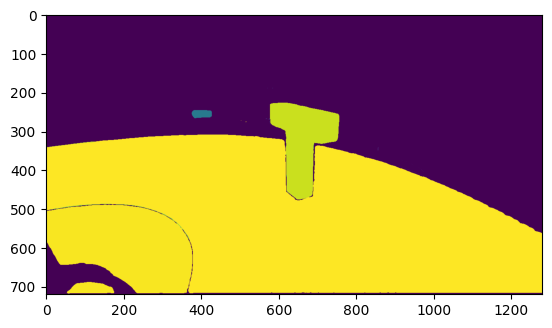

In [50]:
plt.imshow(group_ids)
plt.show()

In [51]:
int_group_ids = group_ids.copy()
int_group_ids[~np.isin(int_group_ids, np.asarray(pcd_groups.colors)[:, 0])] = -1
plt.imshow(int_group_ids)

NameError: name 'pcd_groups' is not defined

In [28]:
np.unique(int_group_ids)

array([-1,  3, 12, 34, 61, 65, 70, 76, 78, 84, 85], dtype=int32)

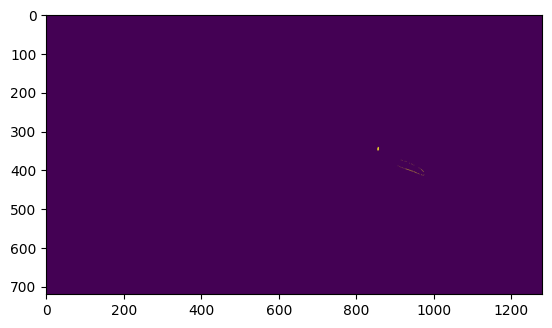

In [39]:
plt.imshow(group_ids == 3)

In [28]:
np.unique(group_ids)

array([-1,  3,  6, 12, 15, 31, 33, 34, 38, 39, 42, 43, 45, 48, 51, 54, 55,
       57, 61, 63, 65, 66, 70, 76, 78, 82, 84, 85], dtype=int32)

In [42]:
np.unique(pcd_dict['group'])

array([-1,  3,  6, 12, 15, 31, 33, 34, 38, 39, 42, 43, 45, 48, 51, 54, 55,
       57, 61, 63, 65, 66, 70, 76, 78, 82, 84, 85], dtype=int16)

In [24]:
np.unique(np.asarray(pcd_groups.colors)[:, 0])

array([-1.,  3., 12., 15., 31., 33., 34., 42., 43., 45., 48., 54., 55.,
       57., 61., 65., 66., 70., 76., 78., 84., 85.])

In [14]:
from segmenter import seg_pcd

pcd_dict = seg_pcd(d, mask_generator, voxelize, None,intermediate_outputs_path, workspace_voxels=workspace_voxels)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pcd_dict['coord'])
pcd.colors = o3d.utility.Vector3dVector(pcd_dict['color'])
o3d.visualization.draw_geometries([pcd])


/home/david/projects/deg/dependencies/SegmentAnything3D/segmenter.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  color=torch.tensor(observation_frame.color).cuda(),
/home/david/projects/deg/dependencies/SegmentAnything3D/segmenter.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_WV=torch.tensor(observation_frame.X_WV),
/home/david/projects/deg/dependencies/SegmentAnything3D/segmenter.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  K=torch.tensor(observation_frame.K),
/home/david/projects/deg/dependencies/SegmentAnythin

Round 1: merging 5 point clouds


/home/david/projects/deg/dependencies/SegmentAnything3D/.pixi/envs/default/lib/python3.11/site-packages/pointops/query.py:19: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  idx = torch.cuda.IntTensor(m, nsample).zero_()


Round 2: merging 3 point clouds
Round 3: merging 2 point clouds


TypeError: tuple indices must be integers or slices, not str

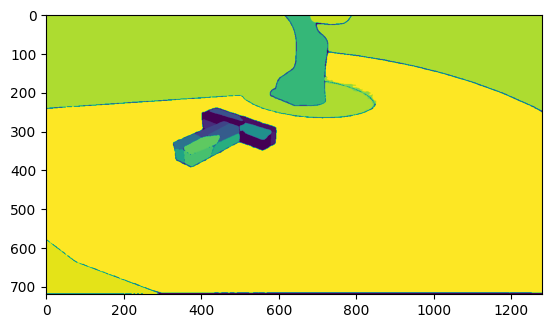

In [6]:
from PIL import Image
import numpy as np
img = Image.open("/home/david/projects/SegmentAnything3D/outputs/notebook/segments/side.png")
group_ids = np.array(img, dtype=np.int16)
plt.imshow(group_ids)
plt.show()

In [7]:
import logging
ch = logging.StreamHandler()
pb.logger.setLevel(logging.DEBUG)
pb.logger.addHandler(ch)

In [79]:
pb.initialize_scene(d, None, intermediate_outputs_path)


/home/david/projects/SegmentAnything3D/.venv/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch

OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 9.77 GiB of which 576.38 MiB is free. Including non-PyTorch memory, this process has 8.51 GiB memory in use. Of the allocated memory 7.12 GiB is allocated by PyTorch, and 1.13 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [7]:
pb.extract_object_and_table_groups(pcd_dict, d)

([0, 2, 3, 4], 1)

In [8]:
pcd = o3d.geometry.PointCloud()
mask = pcd_dict['group'] == 0
pcd.points = o3d.utility.Vector3dVector(pcd_dict['coord'][mask] )
pcd.colors = o3d.utility.Vector3dVector(pcd_dict['color'][mask])
pcd.normals = o3d.utility.Vector3dVector(pcd_dict['normals'][mask])
#o3d.visualization.draw_geometries([pcd])
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, 0.03)
#mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

KeyboardInterrupt: 

In [157]:
(pcd_dict['coord'].shape,
pcd_dict['color'].shape,
pcd_dict['normals'].shape)


((237029, 3), (237029, 3), (237029, 3))

In [168]:
# find nan normals
mask = np.isnan(pcd_dict['color'])
pcd_dict['color'][mask]


array([], dtype=float64)

In [163]:
pcd_dict['normals'][231]

array([-3.54463351e-04,  9.62840451e-04, -9.99999464e-01])

In [169]:
radii = [0.005, 0.01, 0.02]
pcd = o3d.geometry.PointCloud()
#mask = (pcd_dict['group'] == 0)
pcd.points = o3d.utility.Vector3dVector(pcd_dict['coord'] )
pcd.colors = o3d.utility.Vector3dVector(pcd_dict['color'])
pcd.normals = o3d.utility.Vector3dVector(pcd_dict['normals'])

pcd = pcd.normalize_normals()
#o3d.visualization.draw_geometries([pcd])
#

#mesh.compute_vertex_normals()
#pcd.estimate_normals()
mesh, density = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)
#mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
#    pcd, o3d.utility.DoubleVector(radii))
#mesh.compute_vertex_normals()

# Remove low-density vertices
#vertices_to_remove = density < np.quantile(density, 0.05)
#mesh.remove_vertices_by_mask(vertices_to_remove)


o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)
 

[WARNING] /root/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.Initialize.inl (Line 193)
          Initialize
          Found bad data: 231


In [9]:
mesh = pb.construct_mesh(pcd_dict)
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

[WARNING] /root/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.Initialize.inl (Line 193)
          Initialize
          Found bad data: 228


In [12]:
meshes = pb.get_object_meshes(pcd_dict, d)
o3d.visualization.draw_geometries(meshes, mesh_show_back_face=True)




[WARNING] /root/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.Initialize.inl (Line 193)
          Initialize
          Found bad data: 228


[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


In [13]:
t_mesh = meshes[0]
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(t_mesh, 0.007)
o3d.visualization.draw_geometries([voxel_grid])

In [14]:
particles = pb.fill_mesh_with_particles(t_mesh)
#particles = pb.match_mesh_with_particles(t_mesh)

Dims: [15 15  3]


In [16]:
# for each particle instantiate a sphere at that location
spheres = []
for p in particles:
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=p.radius)
    sphere.paint_uniform_color([1, 0, 0])
    sphere.translate(p.xyz)
    spheres.append(sphere)
o3d.visualization.draw_geometries(spheres + [t_mesh], mesh_show_back_face=True)

In [190]:
o3d.visualization.draw_geometries([meshes[0]], mesh_show_back_face=True)

In [173]:
import pymeshfix

In [174]:
v = np.array(obj_mesh.vertices)
t = np.array(obj_mesh.triangles)
v.shape, t.shape

((3843, 3), (7419, 3))

In [180]:
v = np.array(obj_mesh.vertices)
t = np.array(obj_mesh.triangles)
nv, nt = pymeshfix.clean_from_arrays(v,t, verbose=True)
clean_obj_mesh = o3d.geometry.TriangleMesh()
clean_obj_mesh.vertices = o3d.utility.Vector3dVector(nv)
clean_obj_mesh.triangles = o3d.utility.Vector3iVector(nt)
o3d.visualization.draw_geometries([clean_obj_mesh], mesh_show_back_face=True)



INFO- Loaded 110556 vertices and 218620 faces.
Patching holes...
Patched 21 holes
Fixing degeneracies and intersections

100% done 
INFO- ********* ITERATION 0 *********
INFO- Removing degeneracies...
INFO- Removing self-intersections...

99 % done   
INFO- 20482 intersecting triangles have been selected.

99 % done   
INFO- 6388 intersecting triangles have been selected.

99 % done   
INFO- 1038 intersecting triangles have been selected.
INFO- ********* ITERATION 1 *********
INFO- Removing degeneracies...
INFO- Removing self-intersections...

99 % done   ne   
INFO- 366 intersecting triangles have been selected.

99 % done   
INFO- 258 intersecting triangles have been selected.

99 % done   
INFO- 159 intersecting triangles have been selected.
INFO- ********* ITERATION 2 *********
INFO- Removing degeneracies...
INFO- Removing self-intersections...

99 % done   
INFO- 375 intersecting triangles have been selected.

99 % done   done   
INFO- 77 intersecting triangles have been selected.

In [135]:
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(clean_obj_mesh, 0.007)
o3d.visualization.draw_geometries([voxel_grid])



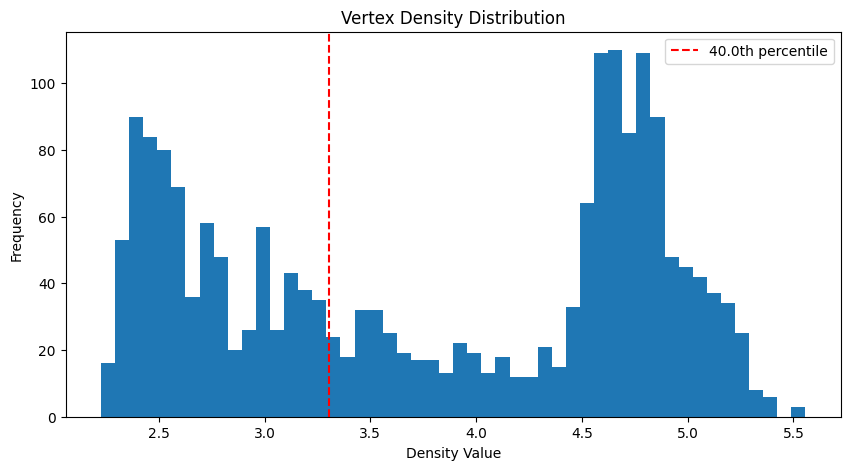

In [34]:
# Plot density histogram
plt.figure(figsize=(10, 5))
plt.hist(density, bins=50)
plt.xlabel('Density Value')
plt.ylabel('Frequency')
plt.title('Vertex Density Distribution')

# Add vertical line for threshold
threshold = np.quantile(density, 0.4)
plt.axvline(x=threshold, color='r', linestyle='--', 
            label=f'{0.4*100}th percentile')
plt.legend()
plt.show()

In [11]:
o3d.visualization.draw_geometries([pcd], point_show_normal=True)

In [77]:
pcd2_dict = pb.get_pcd(d.frames[0], mask_generator, intermediate_outputs_path)


Downloading/Locating SAM checkpoint...
Sam checkpoint in located at /home/david/.frame-seg-init/models/sam_vith.pth
/home/david/projects/SegmentAnything3D/particle_builder.py:125: RuntimeWarning: invalid value encountered in cast
  return save_dict


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0000001..0.99999046].


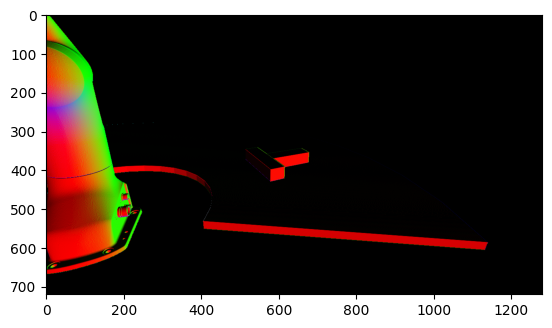

In [76]:
frame = d.frames[0] 
normals = pb.normals_from_depth(frame.depth, frame.K)

normals = normals.view(-1, 3) @ frame.X_WV_opencv[:3, :3].cuda().T
normals = normals.reshape(frame.color.shape)

plt.imshow(normals.cpu().numpy())
plt.show()


In [70]:
normals.shape

torch.Size([921600, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.999998].


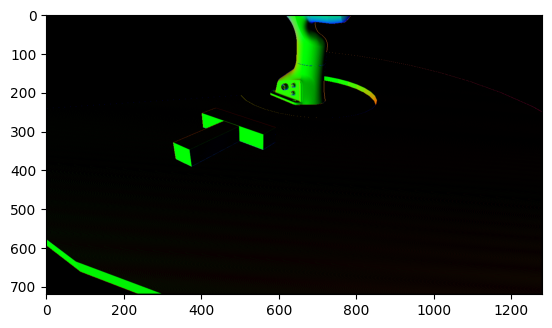

In [73]:
frame = d.frames[1] 
normals = pb.normals_from_depth(frame.depth, frame.K)

normals = (frame.X_WV_opencv[:3, :3].cuda() @ normals.view(-1, 3).cuda().T).T
normals = normals.reshape(frame.color.shape)

plt.imshow(normals.cpu().numpy())
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99999994..0.9999753].


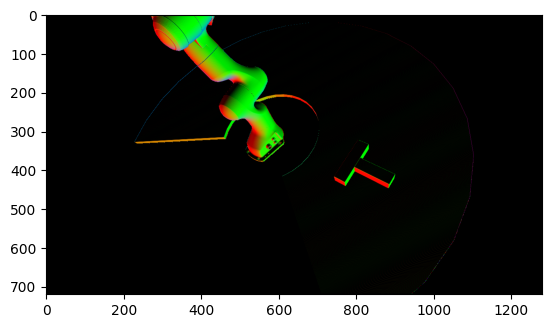

In [74]:
frame = d.frames[3] 
normals = pb.normals_from_depth(frame.depth, frame.K)

normals = (frame.X_WV_opencv[:3, :3].cuda() @ normals.view(-1, 3).cuda().T).T
normals = normals.reshape(frame.color.shape)

plt.imshow(normals.cpu().numpy())
plt.show()

In [78]:
pcd2 = o3d.geometry.PointCloud()
pcd3_dict = pcd2_dict
#pcd3_dict = voxelize(pcd2_dict)

pcd2.points = o3d.utility.Vector3dVector(pcd3_dict['coord'][::100])
pcd2.colors = o3d.utility.Vector3dVector(pcd3_dict['color'][::100])
pcd2.normals = o3d.utility.Vector3dVector(pcd3_dict['normals'][::100])
#pcd3 = pcd2.uniform_down_sample(every_k_points=10)
#pcd4 = pcd3.normalize_normals()
o3d.visualization.draw_geometries([pcd2], point_show_normal=True)

In [54]:
pcd2_dict['coord'].shape

(921600, 3)

In [55]:
pcd2_dict['color'].shape

(921600, 3)

In [56]:
pcd2_dict['normals'].shape

(921600, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


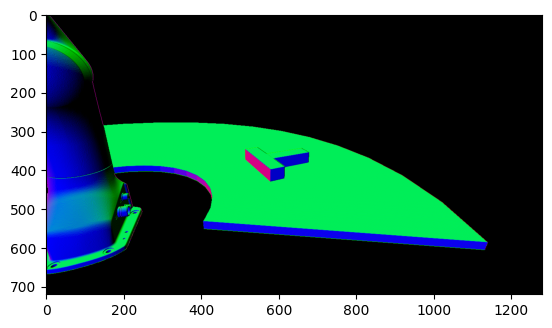

In [59]:
plt.imshow(pcd2_dict['normals'].reshape(frame.color.shape))
plt.show()

In [57]:
pcd2_dict['group'].shape

(921600,)

In [44]:
frame.depth[frame.depth > 0].shape


torch.Size([280653])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


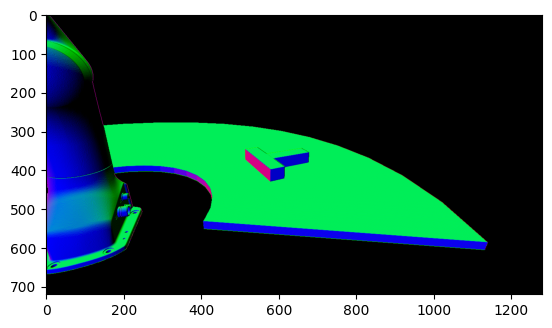

In [26]:
plt.imshow(np.array(pcd2.normals).reshape(frame.color.shape))
plt.show()

In [42]:
np.array(pcd3.normals)

array([], shape=(0, 3), dtype=float64)

In [33]:
pcd2_dict['normals']

array([[-0.98713738,  0.10990769, -0.11610405],
       [-0.97471774,  0.09768923, -0.2009531 ],
       [-0.96052033,  0.17513835, -0.2161648 ],
       ...,
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

In [40]:
np.array(pcd2.normals)


array([[-0.98713738,  0.10990769, -0.11610405],
       [-0.97471774,  0.09768923, -0.2009531 ],
       [-0.96052033,  0.17513835, -0.2161648 ],
       ...,
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])